# Factors Affecting Loan Outcome and Interest Rate

## Dataset Overview
This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income among many others.
I have only Extracted 30 variables out of the original dataframe for easier analysis and visualization.

## Investigation Overview
The main focus of this investigation is to identify the different factors that could have an impact on the outcome of the loan as well as the loan interest rate. I have examined several of these factors including the borrowers monthly income, the loan origianl amount among other variables.

In [2]:
# import the necessary packages for the investigation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings 
import warnings
warnings.simplefilter("ignore")

In [3]:
# load the data into the working environment
loan_df = pd.read_csv('prosperLoanData.csv')

In [4]:
# choosing variables to work with
df = loan_df[['ListingKey', 'ListingNumber', 'Term', 'LoanStatus','BorrowerAPR', 'BorrowerRate', 'LenderYield',
              'ProsperRating (Alpha)', 'ProsperScore','ListingCategory (numeric)', 'BorrowerState', 'OnTimeProsperPayments',
              'Occupation','EmploymentStatus', 'EmploymentStatusDuration','AvailableBankcardCredit','AmountDelinquent',
              'CurrentDelinquencies','IsBorrowerHomeowner', 'IncomeRange', 'StatedMonthlyIncome','LoanOriginalAmount',
              'LoanOriginationDate','LoanOriginationQuarter','MonthlyLoanPayment', 'Recommendations', 'Investors']]


In [5]:
#preliminary wrangling 
## mapping numeric values of listing category into written values as provided in the data dictionary)
listing_category = {0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement',3: 'Business',
4: 'Personal Loan',5: 'Student Use',6: 'Auto',7: 'Other',8: 'Baby&Adoption',9: 'Boat',10: 'Cosmetic Procedure',
11: 'Engagement Ring',12: 'Green Loan',13: 'Household Expenses',14: 'Large Purchases',15: 'Medical/Dental',
16: 'Motorcycle', 17: 'RV', 18: 'Taxes', 19: 'Vacation',20: 'Wedding Loans'}

def listingcategory(df):
    if df['ListingCategory (numeric)'] in listing_category.keys():
        category = listing_category[df['ListingCategory (numeric)']]
        return category
    else:
        return df['ListingCategory (numeric)']    
df['ListingCategory'] = df.apply(listingcategory, axis=1)

## splitting the LoanOriginationQuarter column into two columns
df['Quarter'] = df['LoanOriginationQuarter'].apply(lambda x : x.split()[0])
df['Year'] = df['LoanOriginationQuarter'].apply(lambda x : x.split()[1])

## changing the data type of LoanOriginationDate into datetime
df['LoanOriginationDate'] = pd.to_datetime(df['LoanOriginationDate'])

## convert Prosper Rating into ordered categorical type
prosper_rating_levels = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'N/A']
prosper_ordered = pd.api.types.CategoricalDtype(ordered = True, categories = prosper_rating_levels)
df['ProsperRating (Alpha)'] = df['ProsperRating (Alpha)'].astype(prosper_ordered)

## Distribution of Loan Status
The Distribution shows that approximately 50% of loans are still current with borrowers keeping up with their payments regularly with no payments are past due. It also shows that about one third of loans are completed. The remaining loans are either Charged off or Defaulted as borrowers failed to make loan payments.

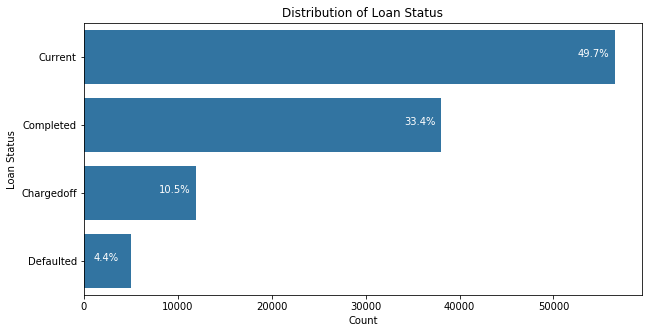

In [6]:
basecolor = sb.color_palette()[0]
n_loans = df.shape[0]
plt.figure(figsize = (10,5))
loanstatus_order = df.LoanStatus.value_counts()
sb.countplot(data = df, y = 'LoanStatus', color = basecolor, order = loanstatus_order.index[:4])
plt.ylabel('Loan Status')
locs, labels = plt.yticks()
for loc, label in zip(locs, labels):
    c = loanstatus_order[label.get_text()]
    s =  '{:0.1f}%'.format(100 * (c / n_loans))
    plt.text(c - 4000 , loc, s, color = 'w')
plt.ylabel('Loan Status')
plt.xlabel('Count')
plt.title('Distribution of Loan Status');

## Distribution of Borrower Rate and Lender Yield
An almost identical theme is shared among the two distributions. They are both normally distributed with one peak between 0.1 and 0.2. There is also a sudden jump in frequency just above 0.3 which is suddenly cut off rather than a gradual drop in frequency. The distribution of the lender yield, however, cover a slightly wider range which accounts for the loan fees.

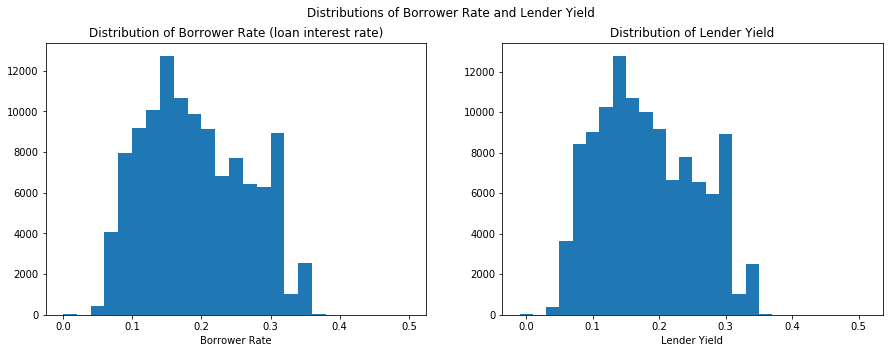

In [7]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
bin_e = np.arange(0, 0.5 + 0.02, 0.02)
plt.hist(data = df, x = 'BorrowerRate', bins = bin_e)
plt.xlabel('Borrower Rate')
plt.title('Distribution of Borrower Rate (loan interest rate)')
plt.subplot(1,2,2)
bin_e = np.arange(-0.01, 0.5 + 0.02, 0.02)
plt.hist(data = df, x = 'LenderYield', bins = bin_e)
plt.xlabel('Lender Yield')
plt.title('Distribution of Lender Yield')
plt.suptitle('Distributions of Borrower Rate and Lender Yield');

## Borrower Rate vs Lender Yield
plotting the two variables using a scatter plot shows a strong positive relationship which is to be expected. As the interest rate on a loan goes up, the lender naturally generate more profit in a commensurate rate.
the plot also shows that most interest rates and lender yield rates fall between 0.1 and 0.3.

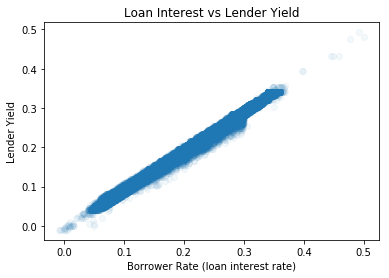

In [8]:
sb.regplot(data = df, x = 'BorrowerRate', y = 'LenderYield', fit_reg = False, scatter_kws = {'alpha' : 1/20}
           , x_jitter = 0.01);
plt.xlabel('Borrower Rate (loan interest rate)')
plt.ylabel('Lender Yield')
plt.title('Loan Interest vs Lender Yield');

## Borrower Rate / Lender Yield vs Loan Amount
Both of the borrower rate and the lender yield are negatively correlated with the Average Loan Amount. Borrowers who took larger loans received a lower loan interest rate, which in turn results in a lower lender yield.

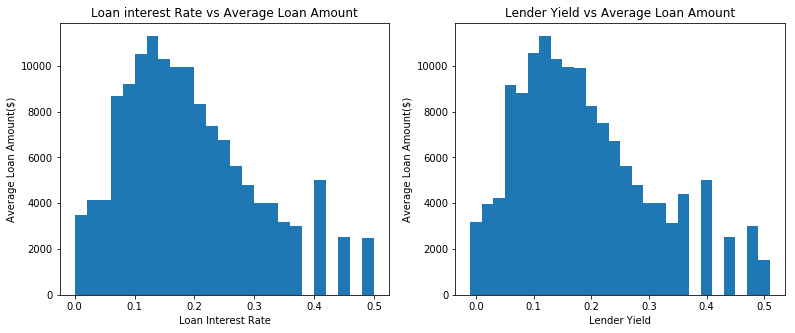

In [9]:
plt.figure(figsize = (13, 5))
plt.subplot(1,2,1)
bin_e = np.arange(0, 0.5 + 0.02, 0.02)
borrower_rate_binned = pd.cut(df['BorrowerRate'], bins = bin_e, right = False, include_lowest = True,
                              labels = False).astype(int)
pts_per_bin = df.groupby(borrower_rate_binned).size()
loan_wt = df['LoanOriginalAmount'] / pts_per_bin[borrower_rate_binned].values
plt.hist(data = df, x = 'BorrowerRate', bins = bin_e, weights = loan_wt)
plt.xlabel('Loan Interest Rate')
plt.ylabel('Average Loan Amount($)')
plt.title('Loan interest Rate vs Average Loan Amount')

plt.subplot(1,2,2)
bin_e = np.arange(-0.01, 0.5 + 0.02, 0.02)
lender_yield_binned = pd.cut(df['LenderYield'], bins = bin_e, right = False, include_lowest = True,
                              labels = False).astype(int)
pts_per_bin = df.groupby(lender_yield_binned).size()
loan_wt = df['LoanOriginalAmount'] / pts_per_bin[lender_yield_binned].values
plt.hist(data = df, x = 'LenderYield', bins = bin_e, weights = loan_wt)
plt.xlabel('Lender Yield')
plt.ylabel('Average Loan Amount($)')
plt.title('Lender Yield vs Average Loan Amount');

## Loan Status Vs Borrower Rate
Borrowers who has taken loans with less interest rates have been able to either complete their loans or keep up with their payments with no payments are past due. On the other hand, Loans with a higher interest rates have been Defaulted or Charged off.

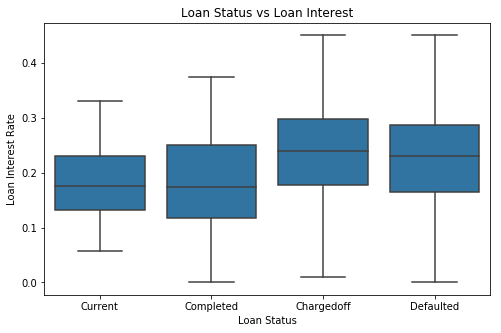

In [10]:
plt.figure(figsize = (8,5))
sb.boxplot(data = df, x = 'LoanStatus', y = 'BorrowerRate', color = basecolor, showfliers = False, 
          order = loanstatus_order.index[:4])
plt.xlabel('Loan Status')
plt.ylabel('Loan Interest Rate')
plt.title('Loan Status vs Loan Interest');

## Loan Status Vs Borrower Monthly Income
As expected, Borrowers with higher monthly incomes have been able to complete or keep up with their loan payments, as opposed to those with lower income whose loans have been either Charged off or Defaulted.

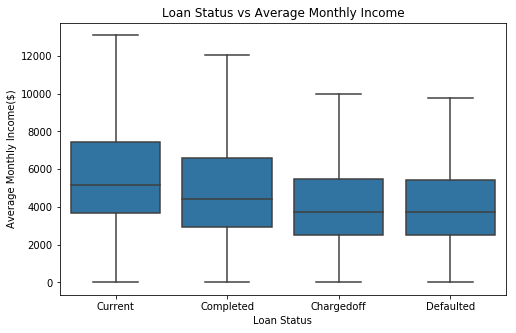

In [11]:
plt.figure(figsize = (8,5))
sb.boxplot(data = df, x = 'LoanStatus', y = 'StatedMonthlyIncome', color = basecolor, showfliers = False, 
          order = loanstatus_order.index[:4])
plt.xlabel('Loan Status')
plt.ylabel('Average Monthly Income($)')
plt.title('Loan Status vs Average Monthly Income');

## Interest Rate and Lender Yield by Prosper Rating
Loan interest rate as well as lender yield are both negatively correlated with the prosper rating of the borrower. Borrowers with a higher prosper rating received loans with a less interest rate which in turn results in a lower lender yield.

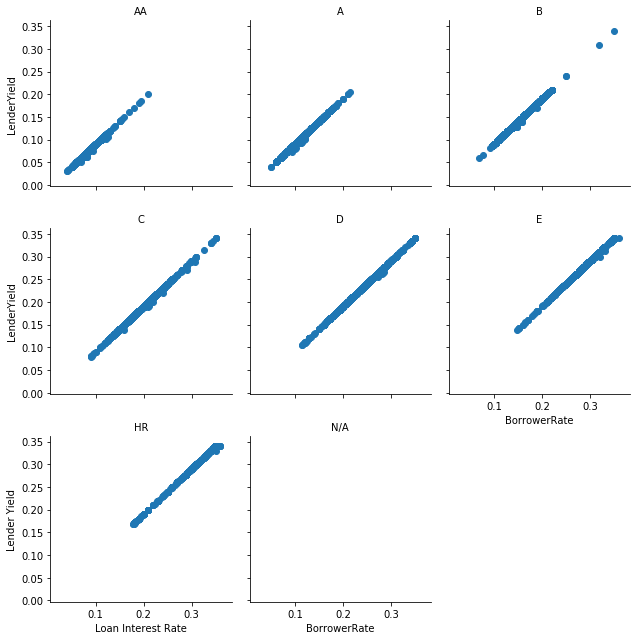

In [12]:
g = sb.FacetGrid(data = df, col = 'ProsperRating (Alpha)', col_wrap = 3)
g.map(plt.scatter, 'BorrowerRate', 'LenderYield')
plt.xlabel('Loan Interest Rate')
plt.ylabel('Lender Yield')
plt.title('Loan Interest Rate and Lender Yield by Prosper Rating')
g.set_titles('{col_name}');

## The Change of Loans Over Time
This timeseries plot shows that the Average loan amounts have increased over time from around 4000 dollars in 2005 to over 11000 dollars in 2014.

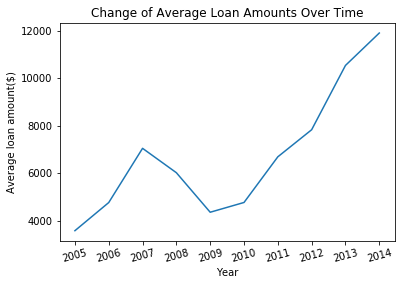

In [13]:
mean_loan_amount = df.groupby('Year')['LoanOriginalAmount'].mean()
plt.errorbar(x = mean_loan_amount.index, y = mean_loan_amount.values)
plt.xlabel('Year')
plt.ylabel('Average loan amount($)')
plt.xticks(rotation = 15)
plt.title('Change of Average Loan Amounts Over Time');